In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as kt
from keras.datasets import fashion_mnist

In [2]:
(x_train_or, y_train), (x_test_or, y_test) = fashion_mnist.load_data()

In [3]:
x_train = ((x_train_or / 255) - 0.5) * 2
x_test = ((x_test_or / 255) - 0.5) * 2

In [4]:
plt.set_cmap("gray")

<Figure size 640x480 with 0 Axes>

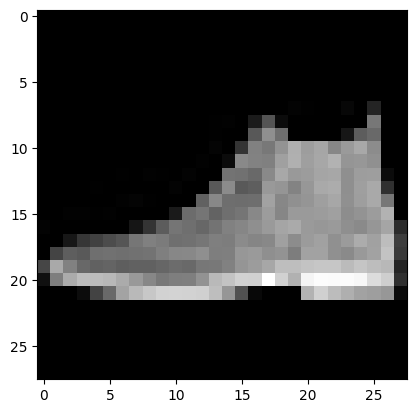

In [5]:
plt.imshow(x_test[0])

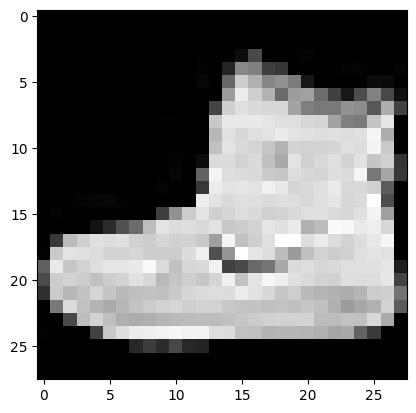

In [6]:
plt.imshow(x_train[0])

In [7]:
# Capas Custom
# 1. Funciones lambda
from keras.layers import Lambda, Input
from keras.models import Model

Square = Lambda(lambda x: x**2)

In [59]:
def search(query_image):
    # codificar la imagen de consulta
    query_image = np.expand_dims(query_image, axis=0)
    query_code = model.predict(query_image)[0]

    # codificar todas las imágenes del dataset
    all_codes = model.predict(x_train)

    # calcular las distancias entre la imagen de consulta y todas las demás
    distances = np.sum(np.square(all_codes - query_code), axis=-1)

    # ordenar las imágenes según la similitud con la imagen de consulta
    sorted_indices = np.argsort(distances)

    # mostrar las imágenes más similares
    for i in range(10):
            image = x_train[sorted_indices[i]].reshape(28,28,1)
            similarity = distances[sorted_indices[i]]
            # print("Imagen {}: Similaridad = {:.2f}".format(i, similarity))
            print('Query image')
            plt.imshow(query_image.reshape(28,28,1), cmap="gray")
            print('------------')
            print(f'Searched image nº {i+1}')
            plt.imshow(image, cmap="gray")
            plt.show()

In [67]:
inp = Input(shape=(2))
# out = Square(inp)
out = Lambda(lambda x: x**2)(inp)
square_model = Model(inp, out)

In [68]:
square_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [69]:
square_model.predict([2])

1/1 [==============================] - 0s 57ms/step


array([4.], dtype=float32)

In [70]:
# Sumar 3 explícitamente

In [71]:
import tensorflow as tf
def sum_3_points(x):
  a, b, c = x[0], x[1], x[2]
  return a + b + c

In [72]:
inp = Input(shape=(3))
out = Lambda(sum_3_points)(inp)
sum_model = Model(inp, out)

In [73]:
sum_model.predict([1,2,3])

1/1 [==============================] - 0s 67ms/step


6.0

In [74]:
# Capas Custom

In [75]:
#  Capa de Sampling

In [76]:
from keras.layers import Layer
class Sampling(Layer):

  def __init__(self):
    super(Sampling, self).__init__()

  def call(self, inputs):
    mu, logstd = inputs
    std = tf.exp(logstd)
    epsilon = tf.random.normal(tf.shape(mu))
    return epsilon * std + mu

In [77]:
mu = Input(shape=2)
logstd = Input(shape=2)
sample = Sampling()([mu, logstd])
sampling_mod = Model([mu, logstd], sample)

In [78]:
sampling_mod.predict([np.array([1., 2.]), np.array([0., -20.])])

1/1 [==============================] - 0s 49ms/step


array([1.1918776, 2.       ], dtype=float32)

In [79]:
from keras.layers.rnn.base_conv_rnn import InputSpec
class KL(Layer):

  def __init__(self, beta=1):
    self.beta = beta
    super(KL, self).__init__()
    

  def call(self, inputs):
    mu, logstd = inputs 
    kl_loss = 0.5 * (tf.square(mu) + tf.exp(logstd * 2.) - 1 - logstd * 2.)
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    self.add_loss(kl_loss)
    return inputs

In [80]:
mu = Input(shape = 2)
logstd = Input(shape = 2)
mu2, logstd2 = KL()([mu, logstd])
kl_model = Model([mu, logstd], [mu2, logstd2])

In [81]:
kl_model.predict([np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 47ms/step


[array([[1., 2.]], dtype=float32), array([[0., 3.]], dtype=float32)]

In [82]:
kl_model.compile()

In [83]:
kl_model.evaluate([np.array([[1., 2.]]), np.array([[0., 3.]])], [np.array([[1., 2.]]), np.array([[0., 3.]])])

1/1 [==============================] - 0s 55ms/step - loss: 200.7144


200.7144012451172

In [84]:
# Fin de la capa KL

In [85]:
# Autoencoder

In [86]:
# Clasificador
from keras.layers import Dense, Flatten, Reshape, Input
from keras.models import Sequential, Model

In [87]:
z_dim = 100
h_dim = 200

In [88]:
encoder_head = Sequential([
    Flatten(input_shape = (28,28)),
    Dense(h_dim, activation = 'relu'),
])

inp = Input((28,28))
h = encoder_head(inp)
mu = Dense(z_dim)(h)
logstd = Dense(z_dim)(h)


# KL Layer
muout, logstdout = KL()([mu, logstd])

# Sampling Layer
z = Sampling()([muout,logstdout])

In [89]:
encoder_mean = Model(inp, mu)
encoder_sample = Model(inp, z)

In [90]:
encoder_sample.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 200)          157000      ['input_9[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 100)          20100       ['sequential_2[0][0]']           
                                                                                                  
 dense_6 (Dense)                (None, 100)          20100       ['sequential_2[0][0]']           
                                                                                            

In [91]:
encoder_sample.predict(x_train[3:4])

1/1 [==============================] - 0s 71ms/step


array([[ 0.0885731 ,  1.1076247 , -0.3379203 ,  0.15917191,  2.0958087 ,
         1.2859607 , -0.03357216, -0.8385653 ,  1.1904092 ,  0.3886273 ,
         0.10887049, -0.86318046,  1.6678178 , -0.29396886,  1.3241371 ,
        -0.3266735 , -0.39316374, -0.924538  , -0.17542478, -0.14988112,
        -0.03435374, -0.6152676 ,  5.021603  ,  0.3317393 ,  0.9799011 ,
        -2.6282587 , -1.0597774 , -0.4274245 , -0.22301191, -0.55729306,
         1.3385525 ,  0.1808852 ,  0.51712984,  0.17192554, -0.93238354,
         1.6309941 ,  0.46966904,  1.1880887 , -0.703387  , -0.18243223,
         0.01508552, -0.3804756 ,  0.45310098,  1.8917723 ,  0.15372491,
         1.2874124 ,  0.15818362,  1.3973327 ,  0.19394544, -3.8918672 ,
        -0.20501254, -0.6129734 ,  1.098459  ,  0.19759741,  0.7214768 ,
        -2.1684785 , -1.3234982 , -0.02670062,  0.41331035,  3.1293497 ,
        -1.1426396 , -1.2744107 , -1.7761772 , -2.3267207 , -1.1362706 ,
        -0.92137754, -0.73337775,  0.6637368 , -0.1

In [92]:
# Decoder

decoder = Sequential([
    Dense(h_dim, activation='relu', input_shape = (z_dim,)),
    Dense(28*28, activation='tanh'),
    Reshape((28,28))
])

In [93]:
vae = Sequential([encoder_mean, decoder])

1/1 [==============================] - 0s 62ms/step


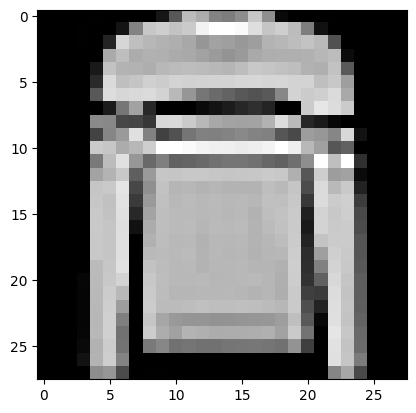

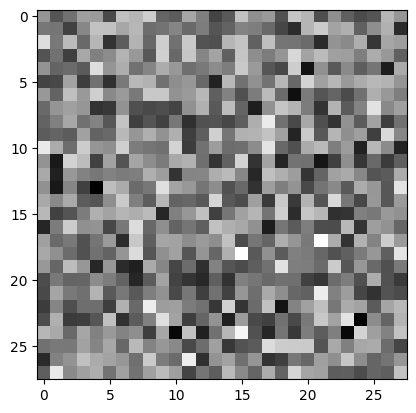

In [94]:
img = 5
plt.imshow(x_train[img])
plt.figure()
plt.imshow(vae.predict(x_train[img:img+1])[0])

In [95]:
from keras.losses import MSE
vae.compile(optimizer = 'adam', loss=lambda x,y: MSE(x,y)*28*28)

In [96]:
n_epochs = 60
batch_size = 128

history = vae.fit(x_train, x_train, validation_data = (x_test, x_test), batch_size=batch_size, epochs=n_epochs)

Epoch 1/60
469/469 [==============================] - 3s 6ms/step - loss: 20.9636 - val_loss: 12.6381
Epoch 2/60
469/469 [==============================] - 2s 5ms/step - loss: 11.2596 - val_loss: 10.2562
Epoch 3/60
469/469 [==============================] - 2s 5ms/step - loss: 9.6257 - val_loss: 9.1621
Epoch 4/60
469/469 [==============================] - 2s 5ms/step - loss: 8.7489 - val_loss: 8.4615
Epoch 5/60
469/469 [==============================] - 2s 5ms/step - loss: 8.1665 - val_loss: 7.9688
Epoch 6/60
469/469 [==============================] - 2s 4ms/step - loss: 7.7387 - val_loss: 7.5948
Epoch 7/60
469/469 [==============================] - 2s 4ms/step - loss: 7.4074 - val_loss: 7.3345
Epoch 8/60
469/469 [==============================] - 2s 4ms/step - loss: 7.1525 - val_loss: 7.1271
Epoch 9/60
469/469 [==============================] - 2s 4ms/step - loss: 6.9608 - val_loss: 6.9643
Epoch 10/60
469/469 [==============================] - 2s 4ms/step - loss: 6.7984 - val_loss: 6.

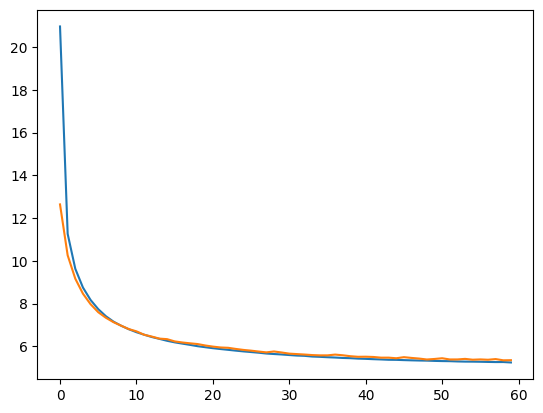

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

1/1 [==============================] - 0s 63ms/step


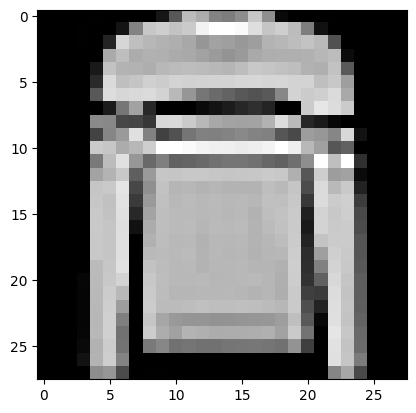

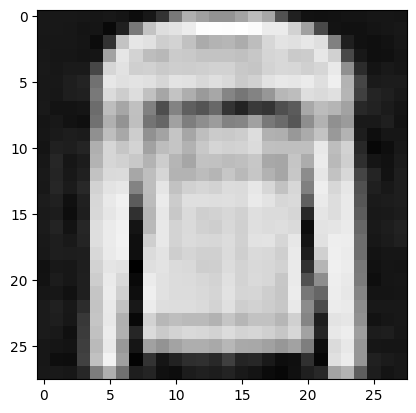

In [98]:
img = 5
plt.imshow(x_train[img])
plt.figure()
plt.imshow(vae.predict(x_train[img:img+1])[0])

In [123]:
database = encoder_mean.predict(x_train)

1875/1875 [==============================] - 2s 1ms/step


In [145]:
def search_image(query_image):
    pca_image = encoder_mean.predict(query_image)
    distances = np.sum(np.square(database - pca_image), axis=-1)
    sorted_indices = np.argsort(distances)
    i = 0
    image = x_train[sorted_indices[i]].reshape(28,28,1)
    similarity = distances[sorted_indices[i]]
    # print("Imagen {}: Similaridad = {:.2f}".format(i, similarity))
    print('Query image')
    plt.imshow(query_image, cmap="gray")
    print('------------')
    plt.figure()
    print(f'Searched image nº {i+1}')
    plt.imshow(image, cmap="gray")
    plt.show()

1/1 [==============================] - 0s 35ms/step
Query image
------------
Searched image nº 1


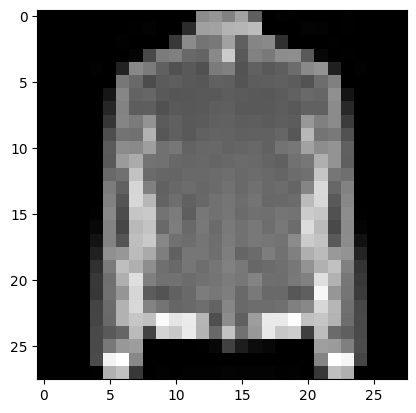

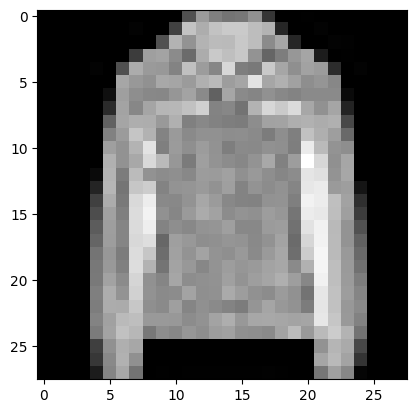

In [153]:
img = 425
search_image(x_test[img])